<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [84]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [85]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [86]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**
Неоптимальный размер пакета может замедлить обучение: слишком маленький размер может привести к большому количеству маленьких обновлений, а слишком большой размер пакета требует больше времени на обновление весов модели и может замедлить обучение, особенно на больших датасетах.

Посмотрим на какую-нибудь картинку:

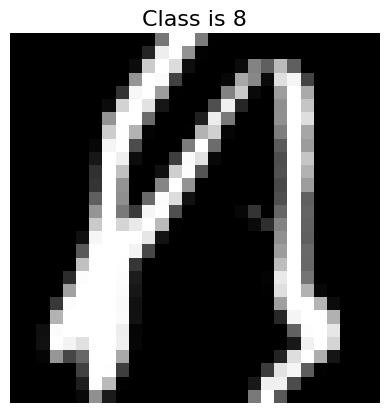

In [87]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





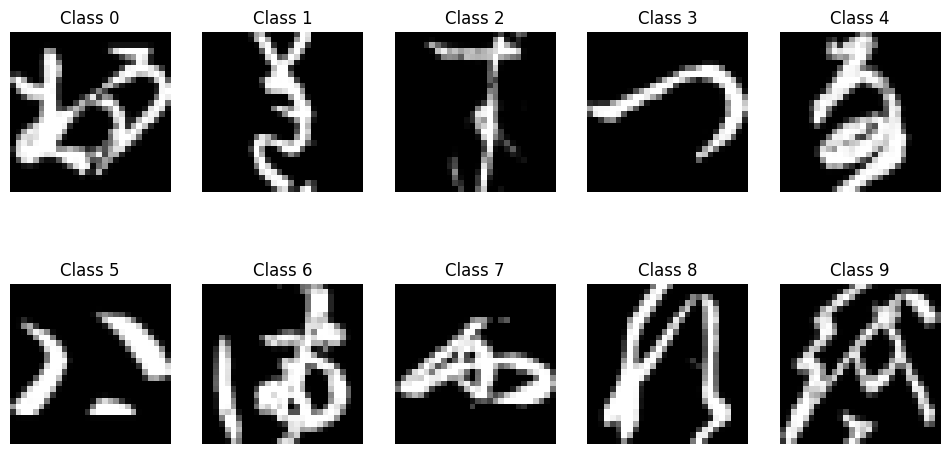

In [88]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
axs = axs.ravel()

for i in range(10):
    class_images = []
    for j in range(len(trainset)):
        image, label = trainset[j]
        if label == i and len(class_images) < 1:
            class_images.append(image)
    axs[i].imshow(class_images[0][0], cmap='gray')
    axs[i].axis("off")
    axs[i].set_title(f"Class {i}")
plt.show()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [89]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation = nn.ReLU()
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) # превращаем картинку в вектор
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        logits = self.fc3(x)
        
        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?



**Ответ:**

In [90]:
weights = 28*28*256 + 256*128 + 128*10
biases = 256 + 128 + 10
trainable_parameters = weights + biases
print('Количество обучаемых параметров:', trainable_parameters)

Количество обучаемых параметров: 235146


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [91]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [92]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [93]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.9236
Epoch=2 loss=0.4487
Epoch=3 loss=0.3506
Epoch=4 loss=0.2921
Epoch=5 loss=0.2508
Epoch=6 loss=0.2173
Epoch=7 loss=0.1905
Epoch=8 loss=0.1664
Epoch=9 loss=0.1477
Epoch=10 loss=0.1302


In [94]:
get_accuracy(fc_net, testloader)

0.8712

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [95]:
mean = 0
std = 0
for images, _ in trainloader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
mean /= len(trainloader.dataset)
std /= len(trainloader.dataset)
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

tensor([0.1918]) tensor([0.3385])


In [96]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [97]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6744
Epoch=2 loss=0.2937
Epoch=3 loss=0.2159
Epoch=4 loss=0.1660
Epoch=5 loss=0.1320
Epoch=6 loss=0.1074
Epoch=7 loss=0.0877
Epoch=8 loss=0.0708
Epoch=9 loss=0.0582
Epoch=10 loss=0.0467


In [98]:
get_accuracy(fc_net, testloader)

0.9017

Как изменилась `accuracy` после нормализации?

> Из `0.8712` в `0.9017`, not bad

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [99]:
activations = [nn.Sigmoid(), nn.GELU(), nn.Tanh()]

n_epochs = 10
loss_history = []

for activation in activations:
    print(f'{activation = }')
    fc_net = FCNet()
    fc_net.activation = activation
    optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = fc_net(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))
        print(f"Epoch={epoch+1} loss={loss_history[-1]:.4f}")

    accuracy = get_accuracy(fc_net, testloader)
    print(f'{accuracy = }\n')


activation = Sigmoid()
Epoch=1 loss=1.5351
Epoch=2 loss=0.7312
Epoch=3 loss=0.5294
Epoch=4 loss=0.4326
Epoch=5 loss=0.3660
Epoch=6 loss=0.3148
Epoch=7 loss=0.2731
Epoch=8 loss=0.2389
Epoch=9 loss=0.2101
Epoch=10 loss=0.1853
accuracy = 0.858

activation = GELU(approximate='none')
Epoch=1 loss=0.6498
Epoch=2 loss=0.2762
Epoch=3 loss=0.1990
Epoch=4 loss=0.1512
Epoch=5 loss=0.1190
Epoch=6 loss=0.0945
Epoch=7 loss=0.0757
Epoch=8 loss=0.0596
Epoch=9 loss=0.0472
Epoch=10 loss=0.0377
accuracy = 0.901

activation = Tanh()
Epoch=1 loss=0.7813
Epoch=2 loss=0.3843
Epoch=3 loss=0.2563
Epoch=4 loss=0.1831
Epoch=5 loss=0.1347
Epoch=6 loss=0.0995
Epoch=7 loss=0.0743
Epoch=8 loss=0.0548
Epoch=9 loss=0.0403
Epoch=10 loss=0.0290
accuracy = 0.9034



С использованием какой функции активации удалось досчить наибольшей `accuracy`?

> **Tanh()**, `accuracy = 0.9034`

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [104]:
fc_net = FCNet()
fc_net.activation = nn.Tanh()
loss_function = nn.CrossEntropyLoss()
lr = 0.001

optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)


n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

accuracy_adam = get_accuracy(fc_net, testloader)
print(f'Adam accuracy: {accuracy_adam}\n')


Epoch=1 loss=0.7663
Epoch=2 loss=0.3770
Epoch=3 loss=0.2526
Epoch=4 loss=0.1812
Epoch=5 loss=0.1334
Epoch=6 loss=0.0993
Epoch=7 loss=0.0743
Epoch=8 loss=0.0551
Epoch=9 loss=0.0405
Epoch=10 loss=0.0297
Adam accuracy: 0.9026



In [105]:
optimizer = torch.optim.RMSprop(fc_net.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

accuracy_rmsprop = get_accuracy(fc_net, testloader)
print(f'RMSprop accuracy: {accuracy_rmsprop}\n')

Epoch=1 loss=0.0391
Epoch=2 loss=0.0172
Epoch=3 loss=0.0135
Epoch=4 loss=0.0143
Epoch=5 loss=0.0073
Epoch=6 loss=0.0078
Epoch=7 loss=0.0071
Epoch=8 loss=0.0029
Epoch=9 loss=0.0069
Epoch=10 loss=0.0014
RMSprop accuracy: 0.9058



In [106]:
optimizer = torch.optim.Adagrad(fc_net.parameters(), lr=3e-4)


n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

accuracy_adagrad = get_accuracy(fc_net, testloader)
print(f'Adagrad accuracy: {accuracy_adagrad}\n')

Epoch=1 loss=0.0007
Epoch=2 loss=0.0005
Epoch=3 loss=0.0004
Epoch=4 loss=0.0004
Epoch=5 loss=0.0004
Epoch=6 loss=0.0004
Epoch=7 loss=0.0004
Epoch=8 loss=0.0003
Epoch=9 loss=0.0003
Epoch=10 loss=0.0003
Adagrad accuracy: 0.9082



> Самая большая `accuracy = 0.9082` при использовании **Adagrad**

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [107]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        
        x = torch.max(torch.zeros_like(x), x)

        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [109]:
fc_net = FCNet()
fc_net.activation = CustomReLU()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adagrad(fc_net.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=1.3976
Epoch=2 loss=0.8675
Epoch=3 loss=0.7307
Epoch=4 loss=0.6606
Epoch=5 loss=0.6157
Epoch=6 loss=0.5836
Epoch=7 loss=0.5595
Epoch=8 loss=0.5397
Epoch=9 loss=0.5232
Epoch=10 loss=0.5097


In [110]:
get_accuracy(fc_net, testloader)

0.7162

In [113]:
fc_net = FCNet()
fc_net.activation = nn.ReLU()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adagrad(fc_net.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=1.4179
Epoch=2 loss=0.8704
Epoch=3 loss=0.7295
Epoch=4 loss=0.6581
Epoch=5 loss=0.6138
Epoch=6 loss=0.5826
Epoch=7 loss=0.5594
Epoch=8 loss=0.5390
Epoch=9 loss=0.5225
Epoch=10 loss=0.5087


In [114]:
get_accuracy(fc_net, testloader)

0.7119

> `0.7162` с CustomReLU  
> `0.7119` с ReLU()  
Сошлось)

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

**"Компания лабораторных крыс делает домашнее задание по машинному обучению"**
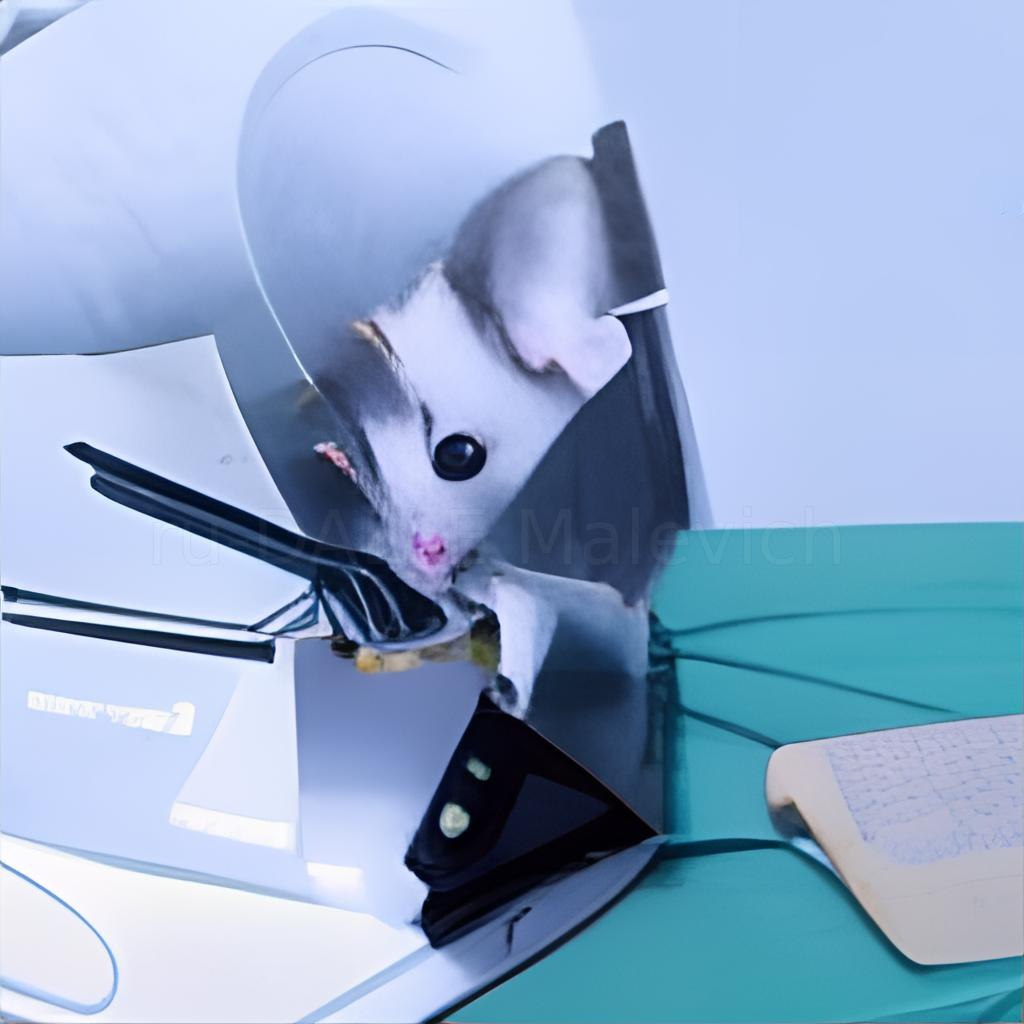

**Грибы-зомби не хотят есть ГМО-горошек**
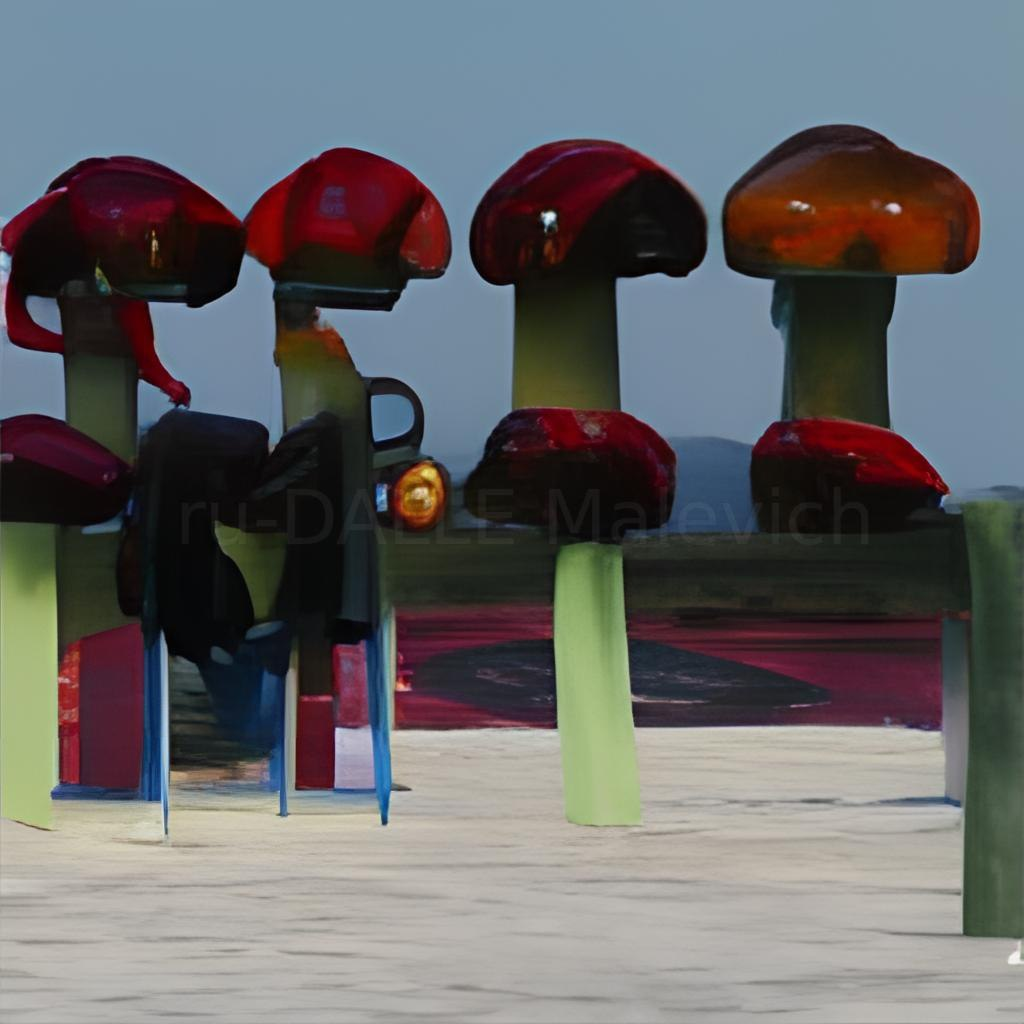

**Пикачу стилизованный по аниме-персонажа**
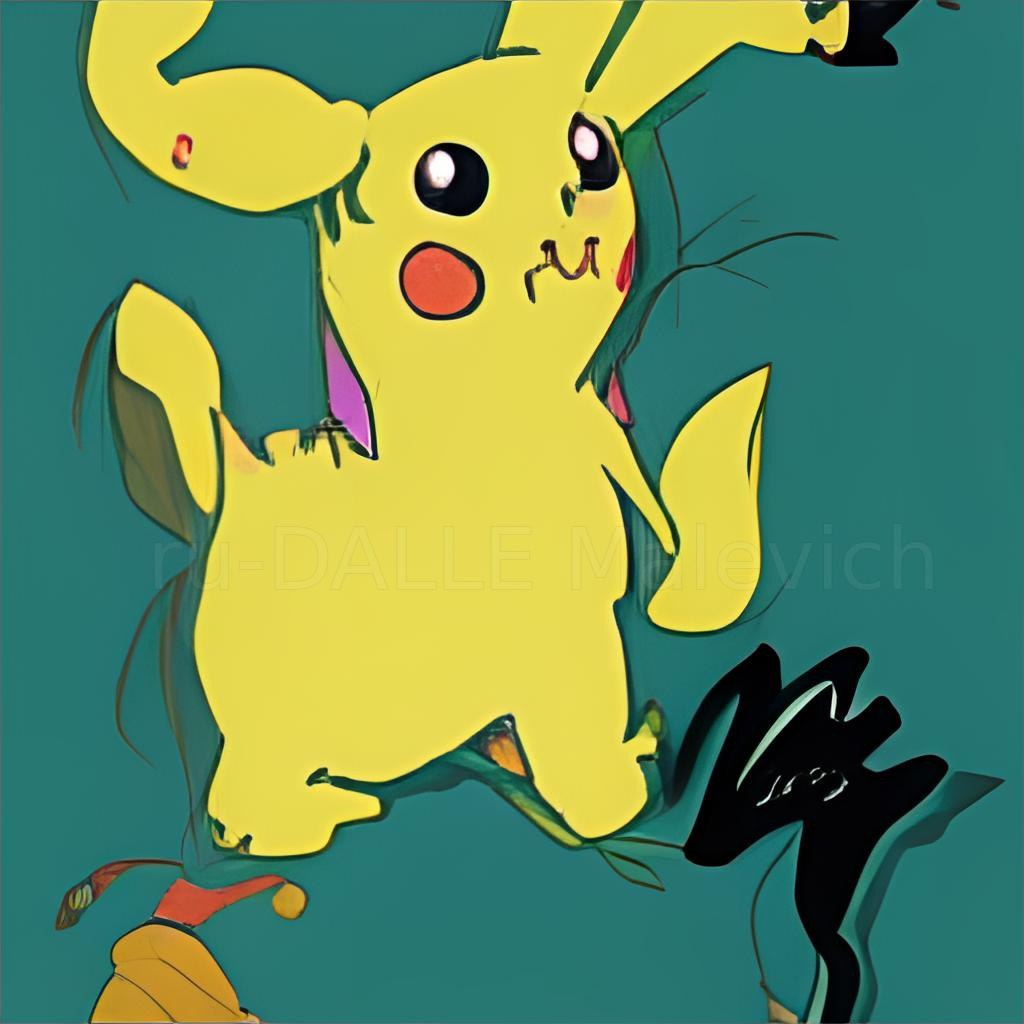